In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

[u'data/names/Arabic.txt', u'data/names/Chinese.txt', u'data/names/Czech.txt', u'data/names/Dutch.txt', u'data/names/English.txt', u'data/names/French.txt', u'data/names/German.txt', u'data/names/Greek.txt', u'data/names/Irish.txt', u'data/names/Italian.txt', u'data/names/Japanese.txt', u'data/names/Korean.txt', u'data/names/Polish.txt', u'data/names/Portuguese.txt', u'data/names/Russian.txt', u'data/names/Scottish.txt', u'data/names/Spanish.txt', u'data/names/Vietnamese.txt']
Slusarski


In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


In [3]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

In [6]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-3.0507 -2.8249 -2.8219 -2.8861 -2.8098 -2.8661 -2.7944 -2.9073 -2.9521 -2.9353

Columns 10 to 17 
-2.8817 -2.9713 -2.8067 -2.8633 -2.8436 -2.9602 -3.0278 -2.8717
[torch.FloatTensor of size 1x18]



In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(u'German', 6)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    print('category =', category, '/ line =', line)

category = English / line = Court
category = French / line = Oliver
category = Dutch / line = Kloet
category = English / line = Polson
category = Spanish / line = Rocha
category = English / line = Robins
category = French / line = Renaud
category = Greek / line = Koumanidis
category = Czech / line = Wiesner
category = Spanish / line = Vasquez


In [9]:
criterion = nn.NLLLoss()

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [11]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

rnn = RNN(n_letters, n_hidden, n_categories)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.4841 Cabello / French ✗ (Spanish)
10000 10% (0m 22s) 1.3841 Wong / Chinese ✓
15000 15% (0m 32s) 1.3340 To / Korean ✗ (Vietnamese)
20000 20% (0m 43s) 1.6519 Klerx / Dutch ✓
25000 25% (0m 52s) 0.3589 Aliberti / Italian ✓
30000 30% (1m 2s) 2.1606 Close / Scottish ✗ (Greek)
35000 35% (1m 11s) 1.5239 Gerojev / Russian ✓
40000 40% (1m 21s) 1.9411 Bader / Arabic ✗ (German)
45000 45% (1m 33s) 1.1775 Faltejsek / Polish ✗ (Czech)
50000 50% (1m 43s) 0.5112 O'Donnell / Irish ✓
55000 55% (1m 53s) 1.1628 Perevuznik / Polish ✗ (Czech)
60000 60% (2m 2s) 1.2372 Yeo / Chinese ✗ (Korean)
65000 65% (2m 12s) 1.6698 Shakhin / Arabic ✗ (Russian)
70000 70% (2m 21s) 0.0306 Dubanowski / Polish ✓
75000 75% (2m 31s) 1.4860 Pecora / Czech ✗ (Italian)
80000 80% (2m 41s) 2.3172 Edmondson / Russian ✗ (English)
85000 85% (2m 51s) 3.1698 Fenyo / Portuguese ✗ (Czech)
90000 90% (3m 0s) 0.0648 Mukubenov / Russian ✓
95000 95% (3m 9s) 1.0053 Haupt / German ✓
100000 100% (3m 19s) 1.3495 Hung / Chinese ✗ (K

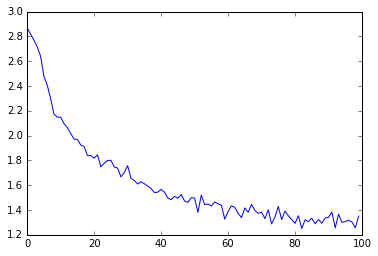

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [22]:
def predict(name):
    line_tensor = Variable(lineToTensor(name))
    hidden = Variable(torch.zeros(1, n_hidden))
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    print(name, categoryFromOutput(output))

In [38]:
predict('Wen')

Wen (u'Chinese', 1)
